In [1]:
import numpy as np
import pandas as pd
from textacy import text_stats, make_spacy_doc
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import itertools
import torch
import os

In [2]:
df_sample = pd.DataFrame(load_dataset("argilla/ultrafeedback-binarized-preferences-cleaned")["train"]).sample(n=1000, random_state=42)
df_clean = df_sample.copy()

In [3]:
df_clean

,source,prompt,chosen,chosen-rating,chosen-model,rejected,rejected-rating,rejected-model
50618,sharegpt,Topics: Wound management for general practitio...,[{'content': 'Topics: Wound management for gen...,5.00,wizardlm-70b,[{'content': 'Topics: Wound management for gen...,3.75,ultralm-13b
23891,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...","[{'content': 'Part 1. Definition In this task,...",4.50,wizardlm-70b,"[{'content': 'Part 1. Definition In this task,...",3.25,vicuna-33b
47103,sharegpt,You will act as an voice changer. You will cha...,[{'content': 'You will act as an voice changer...,4.50,wizardlm-13b,[{'content': 'You will act as an voice changer...,1.75,ultralm-13b
59352,ultrachat,Write a well-researched paper on the physiolog...,[{'content': 'Write a well-researched paper on...,4.75,wizardlm-13b,[{'content': 'Write a well-researched paper on...,3.00,ultralm-13b
58625,ultrachat,Create a step-by-step recipe for making fluffy...,[{'content': 'Create a step-by-step recipe for...,5.00,llama-2-7b-chat,[{'content': 'Create a step-by-step recipe for...,4.50,falcon-40b-instruct
...,...,...,...,...,...,...,...,...
29947,flan_v2_niv2,"Teacher:In this task, you are given a country ...","[{'content': 'Teacher:In this task, you are gi...",2.50,mpt-30b-chat,"[{'content': 'Teacher:In this task, you are gi...",1.25,alpaca-7b
35026,sharegpt,"Yes. Okay. Then, our organization's work is no...","[{'content': 'Yes. Okay. Then, our organizatio...",5.00,llama-2-70b-chat,"[{'content': 'Yes. Okay. Then, our organizatio...",4.50,mpt-30b-chat
58845,ultrachat,How does the Metropolitan Police involve commu...,[{'content': 'How does the Metropolitan Police...,5.00,llama-2-13b-chat,[{'content': 'How does the Metropolitan Police...,4.50,mpt-30b-chat
17161,flan_v2_niv2,"In this task, you are given a sentence and a g...","[{'content': 'In this task, you are given a se...",4.50,llama-2-13b-chat,"[{'content': 'In this task, you are given a se...",4.25,wizardlm-13b


In [4]:
df_clean['chosen'] = df_clean['chosen'].apply(lambda x: x[1]['content'])
df_clean['rejected'] = df_clean['rejected'].apply(lambda x: x[1]['content'])

In [5]:
for i, row in df_clean.iterrows(): #iterate over the dataset to get the Flesch score of each prompt
    chosen_resp = make_spacy_doc(row['chosen'], lang='en_core_web_sm')
    rejected_resp = make_spacy_doc(row['rejected'], lang='en_core_web_sm')
    df_clean.loc[i, 'flesch_score_chosen'] = text_stats.readability.flesch_reading_ease(chosen_resp) 
    df_clean.loc[i, 'flesch_score_rejected'] = text_stats.readability.flesch_reading_ease(rejected_resp) 
    df_clean.loc[i, 'flesch_grade_chosen'] = text_stats.readability.flesch_kincaid_grade_level(chosen_resp)
    df_clean.loc[i, 'flesch_grade_rejected'] = text_stats.readability.flesch_kincaid_grade_level(rejected_resp) 
    df_clean.loc[i, 'gunning_fog_chosen'] = text_stats.readability.gunning_fog_index(chosen_resp) 
    df_clean.loc[i, 'gunning_fog_rejected'] = text_stats.readability.gunning_fog_index(rejected_resp)
    df_clean.loc[i, 'coleman_liau_chosen'] = text_stats.readability.coleman_liau_index(chosen_resp) 
    df_clean.loc[i, 'coleman_liau_rejected'] = text_stats.readability.coleman_liau_index(rejected_resp) 
    df_clean.loc[i, 'automated_readability_chosen'] = text_stats.readability.automated_readability_index(chosen_resp)
    df_clean.loc[i, 'automated_readability_rejected'] = text_stats.readability.automated_readability_index(rejected_resp)

In [6]:
df_clean['length_chosen'] = df_clean['chosen'].apply(lambda x: len(x.strip().split()))
df_clean['length_rejected'] = df_clean['rejected'].apply(lambda x: len(x.strip().split()))


In [9]:
# df_checkpoint = df_clean.copy()

In [10]:
df_clean = df_checkpoint

In [11]:
#Bringing in topics and docs
topics = pd.read_csv("UF_mixedbread_topics.csv")
docs = pd.read_csv("UF_mixedbread_docs.csv")

In [12]:
#Cleaning
topics['topic_id'] = topics['topic_id'].str.extract(r'(\d+)').astype(int)
docs['topic_id'] = docs['topic_id'].str.extract(r'(\d+)').astype(int)

docs['x_cord'] = docs['x_cord'].str.extract(r'(\d+.\d+)').astype(float)
docs['y_cord'] = docs['y_cord'].str.extract(r'(\d+.\d+)').astype(float)

In [13]:
# Merging to get all the data in one place
docs_and_topics = docs.merge(topics, on="topic_id").reset_index(drop=True)
docs_and_topics = docs_and_topics.drop(columns=['term_id', 'doc_id']).rename(columns={'10': 'metadata', 'content': 'prompt'})
df_clean = df_clean.merge(docs_and_topics, on='prompt')

In [14]:
df_clean

,source,prompt,chosen,chosen-rating,chosen-model,rejected,rejected-rating,rejected-model,flesch_score_chosen,flesch_score_rejected,...,automated_readability_chosen,automated_readability_rejected,length_chosen,length_rejected,x_cord,y_cord,topic_id,embeddings,metadata,topic_name
0,sharegpt,Topics: Wound management for general practitio...,General practitioners play a vital role in the...,5.00,wizardlm-70b,Wound management is a crucial aspect of genera...,3.75,ultralm-13b,54.798955,9.508750,...,10.319922,17.114362,476,47,1.583847,12.755462,3,"[0.20282909274101257, -0.05036671459674835, -0...","('metadata', {'source': 'sharegpt', 'rating': ...",Community Health Development
1,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...",Step 1: Identify the language of the post. The...,4.50,wizardlm-70b,Non-hateful\n\nExplanation: This post seems to...,3.25,vicuna-33b,77.527626,68.377061,...,5.876111,7.966163,109,102,1.288237,12.023764,2,"[0.06639007478952408, 0.23666216433048248, -0....","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Communication Options
2,sharegpt,You will act as an voice changer. You will cha...,An umbrella has been brought by her on the way.,4.50,wizardlm-13b,"Alright, just let me know which form of voice ...",1.75,ultralm-13b,103.625000,82.879122,...,0.997000,7.041892,10,36,0.095036,10.451447,14,"[-0.4921853840351105, -0.1649392992258072, -0....","('metadata', {'source': 'sharegpt', 'rating': ...",Language Processing
3,ultrachat,Write a well-researched paper on the physiolog...,Title: The Physiological and Psychological Imp...,4.75,wizardlm-13b,Title: The Physiological and Psychological Imp...,3.00,ultralm-13b,46.861475,32.668039,...,13.018888,16.293186,672,136,2.338906,12.515949,3,"[-0.30388227105140686, 0.15756076574325562, 0....","('metadata', {'source': 'ultrachat', 'rating':...",Community Health Development
4,ultrachat,Create a step-by-step recipe for making fluffy...,"Of course, I'd be happy to help you with that!...",5.00,llama-2-7b-chat,Here is a step-by-step recipe for making fluff...,4.50,falcon-40b-instruct,77.423727,35.692111,...,6.432877,26.404428,370,220,0.034553,8.935261,5,"[-0.05435372143983841, 0.28580591082572937, -0...","('metadata', {'source': 'ultrachat', 'rating':...",Experiencing Food Options
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,flan_v2_niv2,"Teacher:In this task, you are given a country ...","Yes, I understand the problem. The ISO code fo...",2.50,mpt-30b-chat,The ISO code for Anguilla is IM.,1.25,alpaca-7b,87.945000,103.044286,...,1.195000,-1.108571,12,7,1.250797,9.692348,4,"[0.3667982220649719, 0.00017638220742810518, -...","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Programming Concepts
996,sharegpt,"Yes. Okay. Then, our organization's work is no...",Standardizing business processes can have a po...,5.00,llama-2-70b-chat,Business process standardization can have a si...,4.50,mpt-30b-chat,31.161593,29.832635,...,14.712967,17.047459,305,185,3.784499,10.890813,1,"[-0.06229546293616295, -0.48266759514808655, -...","('metadata', {'source': 'sharegpt', 'rating': ...",Business Market Analysis
997,ultrachat,How does the Metropolitan Police involve commu...,Thank you for your question. I'm happy to help...,5.00,llama-2-13b-chat,The Metropolitan Police Service (MPS) involves...,4.50,mpt-30b-chat,51.613578,36.487308,...,13.372588,16.857994,342,332,2.718591,13.339828,12,"[0.34537461400032043, -0.3282298445701599, -0....","('metadata', {'source': 'ultrachat', 'rating':...",Social Impact Analysis
998,flan_v2_niv2,"In this task, you are given a sentence and a g...",Of course! I'd be happy to help. Here's the an...,4.50,llama-2-13b-chat,Cleaner,4.25,wizardlm-13b,92.267872,36.620000,...,3.435270,12.040000,35,1,0.119172,10.988955,14,"[0.35505878925323486, -0.48080533742904663, -0...","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Language Processing


## Subsetting based on accepted/rejectd

In [15]:
rejected_only = df_clean.loc[:, ['source', 'rejected', 'rejected-rating', 'length_rejected', 'flesch_score_rejected', 'flesch_grade_rejected', 'gunning_fog_rejected', 'coleman_liau_rejected', 'automated_readability_rejected', 'rejected-model', 'topic_name']]
accepted_only = df_clean.loc[:, ['source', 'chosen', 'chosen-rating', 'length_chosen', 'flesch_score_chosen', 'flesch_grade_chosen', 'gunning_fog_chosen', 'coleman_liau_chosen', 'automated_readability_chosen','chosen-model', 'topic_name']]

In [16]:
accepted_only_stats = accepted_only.iloc[:, 2:9]

corr = accepted_only_stats.corr()
corr.style.background_gradient(cmap='coolwarm')

,chosen-rating,length_chosen,flesch_score_chosen,flesch_grade_chosen,gunning_fog_chosen,coleman_liau_chosen,automated_readability_chosen
chosen-rating,1.000000,0.346372,-0.189153,0.173948,0.153492,0.037952,0.030435
length_chosen,0.346372,1.000000,-0.346387,0.339645,0.315062,0.093947,0.070817
flesch_score_chosen,-0.189153,-0.346387,1.000000,-0.897434,-0.854115,-0.183273,-0.243107
flesch_grade_chosen,0.173948,0.339645,-0.897434,1.000000,0.927382,0.159617,0.281323
gunning_fog_chosen,0.153492,0.315062,-0.854115,0.927382,1.000000,0.149715,0.260397
coleman_liau_chosen,0.037952,0.093947,-0.183273,0.159617,0.149715,1.000000,0.955383
automated_readability_chosen,0.030435,0.070817,-0.243107,0.281323,0.260397,0.955383,1.000000


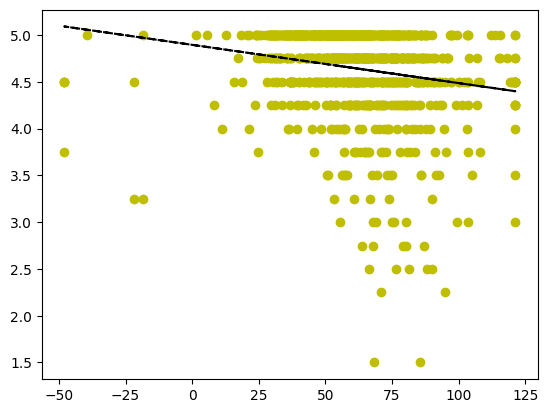

In [17]:
coef = np.polyfit(accepted_only['flesch_score_chosen'], accepted_only['chosen-rating'], 1)
poly1d_fn = np.poly1d(coef)
plt.plot(accepted_only['flesch_score_chosen'], accepted_only['chosen-rating'], 'yo', accepted_only['flesch_score_chosen'], poly1d_fn(accepted_only['flesch_score_chosen']), '--k')


In [18]:
rejected_only_stats = rejected_only.iloc[:, 2:9]
corr = rejected_only_stats.corr()
corr.style.background_gradient(cmap='coolwarm')

,rejected-rating,length_rejected,flesch_score_rejected,flesch_grade_rejected,gunning_fog_rejected,coleman_liau_rejected,automated_readability_rejected
rejected-rating,1.000000,0.334315,-0.169837,0.093403,0.082893,0.109413,0.052926
length_rejected,0.334315,1.000000,-0.211514,0.231746,0.210529,0.153122,0.158555
flesch_score_rejected,-0.169837,-0.211514,1.000000,-0.877652,-0.870518,-0.480373,-0.692095
flesch_grade_rejected,0.093403,0.231746,-0.877652,1.000000,0.955636,0.366601,0.779906
gunning_fog_rejected,0.082893,0.210529,-0.870518,0.955636,1.000000,0.326247,0.728980
coleman_liau_rejected,0.109413,0.153122,-0.480373,0.366601,0.326247,1.000000,0.769464
automated_readability_rejected,0.052926,0.158555,-0.692095,0.779906,0.728980,0.769464,1.000000


# SSLDEDUP

## Recreating the map

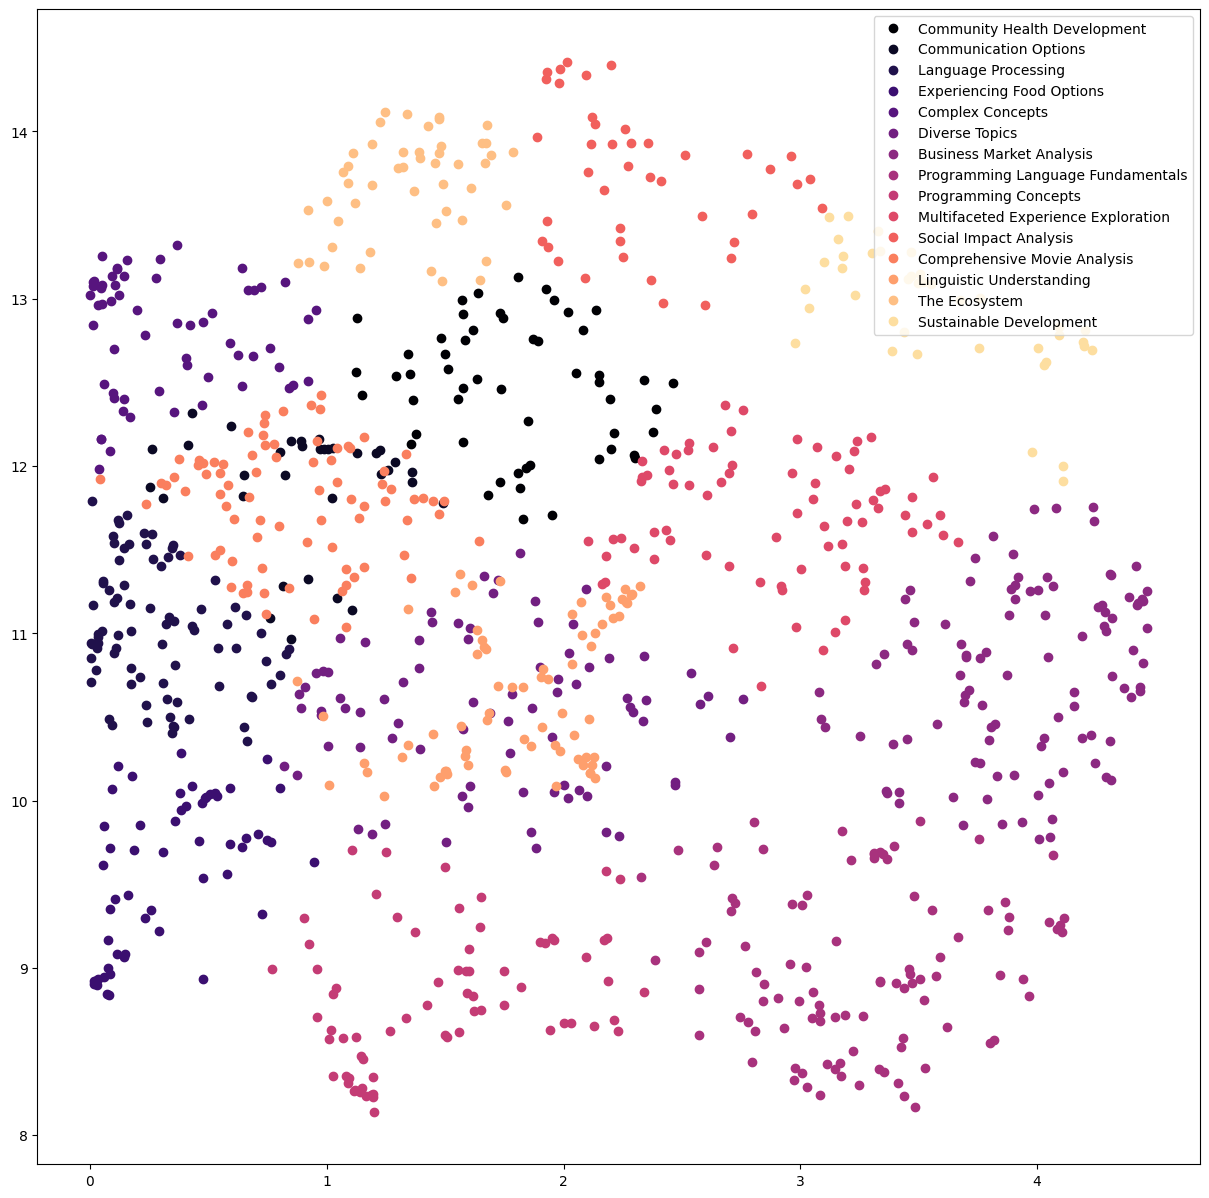

In [19]:
colors = itertools.cycle(plt.cm.magma(np.linspace(0, 1, 16)))
fig, ax = plt.subplots(figsize=(15, 15))
for i in df_clean['topic_name'].unique():
    # Plot the points to see the clusters
    ax.plot(df_clean[df_clean['topic_name'] == i]['x_cord'], 
            df_clean[df_clean['topic_name'] == i]['y_cord'], 
            'o', 
            color=next(colors), 
            label=i)
    ax.legend()

## DeDuplication

In [20]:
centroids = {}
for id in df_clean['topic_id'].unique():
    centroids[id] = (df_clean[df_clean['topic_id'] == id]['x_cord'].mean(), 
                     df_clean[df_clean['topic_id'] == id]['y_cord'].mean()) #centroid is the mean of the x and y coordinates for each topic

df_clean['centroids'] = df_clean['topic_id'].map(centroids) #map the centroid to each datapoint in the dataframe

In [21]:
df_clean['distance'] = df_clean.apply(lambda x: np.sqrt((x['x_cord'] - x['centroids'][0])**2 + (x['y_cord'] - x['centroids'][1])**2), axis=1) #euclidean distance between each point and its centroid

In [22]:
df_clean

,source,prompt,chosen,chosen-rating,chosen-model,rejected,rejected-rating,rejected-model,flesch_score_chosen,flesch_score_rejected,...,length_chosen,length_rejected,x_cord,y_cord,topic_id,embeddings,metadata,topic_name,centroids,distance
0,sharegpt,Topics: Wound management for general practitio...,General practitioners play a vital role in the...,5.00,wizardlm-70b,Wound management is a crucial aspect of genera...,3.75,ultralm-13b,54.798955,9.508750,...,476,47,1.583847,12.755462,3,"[0.20282909274101257, -0.05036671459674835, -0...","('metadata', {'source': 'sharegpt', 'rating': ...",Community Health Development,"(1.7938880699652213, 12.46719014203107)",0.356676
1,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...",Step 1: Identify the language of the post. The...,4.50,wizardlm-70b,Non-hateful\n\nExplanation: This post seems to...,3.25,vicuna-33b,77.527626,68.377061,...,109,102,1.288237,12.023764,2,"[0.06639007478952408, 0.23666216433048248, -0....","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Communication Options,"(0.9073237022932839, 11.880517202265123)",0.406958
2,sharegpt,You will act as an voice changer. You will cha...,An umbrella has been brought by her on the way.,4.50,wizardlm-13b,"Alright, just let me know which form of voice ...",1.75,ultralm-13b,103.625000,82.879122,...,10,36,0.095036,10.451447,14,"[-0.4921853840351105, -0.1649392992258072, -0....","('metadata', {'source': 'sharegpt', 'rating': ...",Language Processing,"(0.2956225843065315, 11.021082524900082)",0.603921
3,ultrachat,Write a well-researched paper on the physiolog...,Title: The Physiological and Psychological Imp...,4.75,wizardlm-13b,Title: The Physiological and Psychological Imp...,3.00,ultralm-13b,46.861475,32.668039,...,672,136,2.338906,12.515949,3,"[-0.30388227105140686, 0.15756076574325562, 0....","('metadata', {'source': 'ultrachat', 'rating':...",Community Health Development,"(1.7938880699652213, 12.46719014203107)",0.547194
4,ultrachat,Create a step-by-step recipe for making fluffy...,"Of course, I'd be happy to help you with that!...",5.00,llama-2-7b-chat,Here is a step-by-step recipe for making fluff...,4.50,falcon-40b-instruct,77.423727,35.692111,...,370,220,0.034553,8.935261,5,"[-0.05435372143983841, 0.28580591082572937, -0...","('metadata', {'source': 'ultrachat', 'rating':...",Experiencing Food Options,"(0.33394973133025424, 9.581079125404358)",0.711843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,flan_v2_niv2,"Teacher:In this task, you are given a country ...","Yes, I understand the problem. The ISO code fo...",2.50,mpt-30b-chat,The ISO code for Anguilla is IM.,1.25,alpaca-7b,87.945000,103.044286,...,12,7,1.250797,9.692348,4,"[0.3667982220649719, 0.00017638220742810518, -...","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Programming Concepts,"(1.4864259353825744, 8.82503681451502)",0.898748
996,sharegpt,"Yes. Okay. Then, our organization's work is no...",Standardizing business processes can have a po...,5.00,llama-2-70b-chat,Business process standardization can have a si...,4.50,mpt-30b-chat,31.161593,29.832635,...,305,185,3.784499,10.890813,1,"[-0.06229546293616295, -0.48266759514808655, -...","('metadata', {'source': 'sharegpt', 'rating': ...",Business Market Analysis,"(3.9330584792529835, 10.747244245865765)",0.206596
997,ultrachat,How does the Metropolitan Police involve commu...,Thank you for your question. I'm happy to help...,5.00,llama-2-13b-chat,The Metropolitan Police Service (MPS) involves...,4.50,mpt-30b-chat,51.613578,36.487308,...,342,332,2.718591,13.339828,12,"[0.34537461400032043, -0.3282298445701599, -0....","('metadata', {'source': 'ultrachat', 'rating':...",Social Impact Analysis,"(2.3290288022586276, 13.723252864111037)",0.546602
998,flan_v2_niv2,"In this task, you are given a sentence and a g...",Of course! I'd be happy to help. Here's the an...,4.50,llama-2-13b-chat,Cleaner,4.25,wizardlm-13b,92.267872,36.620000,...,35,1,0.119172,10.988955,14,"[

In [66]:
cluster_1 = df_clean[df_clean['topic_id'] == 2]

In [67]:
cluster_1 = cluster_1.sort_values(by='distance', ascending=False).reset_index()

In [25]:
import ast

In [68]:
cluster_1['embeddings'] = cluster_1['embeddings'].apply(lambda x: ast.literal_eval(x))

In [69]:
cluster_1['embeddings']

0     [0.4043789803981781, -0.01945103146135807, -0....
1     [0.4238167703151703, 0.013676347211003304, -0....
2     [0.25527212023735046, -0.2548227906227112, 0.1...
3     [0.2149404138326645, -0.139995738863945, 0.312...
4     [0.38311079144477844, -0.1703364998102188, 0.0...
5     [-0.29410815238952637, -0.1861763745546341, -0...
6     [0.4854770302772522, 0.012476152740418911, -1....
7     [-0.29926618933677673, 0.06776953488588333, -0...
8     [0.3219533860683441, 0.19594082236289978, 0.28...
9     [0.032273270189762115, -0.1866275668144226, -0...
10    [-0.34113234281539917, -0.17133860290050507, 0...
11    [0.998162031173706, -0.7570348381996155, 0.119...
12    [-0.06456872820854187, -0.6150475144386292, -0...
13    [-0.17200526595115662, -0.005329711362719536, ...
14    [-0.21407920122146606, -0.38848599791526794, -...
15    [0.06639007478952408, 0.23666216433048248, -0....
16    [-0.08209120482206345, -0.04559241607785225, 0...
17    [-0.01941651478409767, 0.00994730554521083

In [70]:
embeddings = torch.tensor(cluster_1['embeddings'])

In [71]:
embeddings.size()

torch.Size([34, 1024])

In [72]:
pairwise_sim_matrix = embeddings @ embeddings.T

In [73]:
triu_sim_matrix = torch.triu(pairwise_sim_matrix, diagonal=1)
M = torch.max(triu_sim_matrix, dim=0)[0]

In [74]:
M

tensor([  0.0000, 289.6360, 223.8497, 197.2473, 247.9661, 149.6974, 157.0264,
        112.3096, 230.5769, 218.0198, 230.3671, 176.8374, 123.9172, 228.6470,
        290.5718, 227.4918, 230.6318, 280.8348, 237.1337, 221.3939, 240.8009,
        244.7966, 156.9752, 230.9653, 198.7183, 179.8411, 251.4342, 243.3514,
        241.6093, 175.0659, 244.5032, 216.8833, 231.6122, 169.5672])

In [75]:
points_to_keep_from_cluster_i = M <= 1-0.07

In [76]:
points_to_keep_from_cluster_i #uhoh

tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])

Wait maybe those are the wrong embeddings, lets try the coordinates

In [52]:
from sentence_transformers import SentenceTransformer, util
import ast

In [55]:
embeddings1 = cluster_1['embeddings'][0]
embeddings2 = cluster_1['embeddings'][1]

In [56]:
cosine_scores = util.cos_sim(embeddings1, embeddings2)

In [57]:
cosine_scores

tensor([[0.5068]])

In [58]:
embeddings1 @ embeddings2.T

AttributeError: 'list' object has no attribute 'T'

In [59]:
# Retrieve the embeddings from the DataFrame column
embeddings = cluster_1['embeddings'].tolist()

# Compute cosine similarity between embeddings
cos_sim_matrix = util.cos_sim(embeddings, embeddings)

In [60]:
cos_sim_matrix.shape

torch.Size([102, 102])

In [61]:
cos_sim_matrix

tensor([[1.0000, 0.5068, 0.4478,  ..., 0.4819, 0.4590, 0.4550],
        [0.5068, 1.0000, 0.4698,  ..., 0.4771, 0.4531, 0.4237],
        [0.4478, 0.4698, 1.0000,  ..., 0.3927, 0.4732, 0.4152],
        ...,
        [0.4819, 0.4771, 0.3927,  ..., 1.0000, 0.4716, 0.5726],
        [0.4590, 0.4531, 0.4732,  ..., 0.4716, 1.0000, 0.6321],
        [0.4550, 0.4237, 0.4152,  ..., 0.5726, 0.6321, 1.0000]])

In [62]:
triu_sim = torch.triu(pairwise_sim_matrix, diagonal=1)

In [63]:
M_ = torch.max(triu_sim, dim=0)[0]